In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import community as community_louvain
import tqdm
import torch
import scipy.special
import math

from torch import nn
from model.tgn import TGN
from utils.data_processing import get_data, compute_time_statistics
from utils.utils import EarlyStopMonitor, RandEdgeSampler, get_neighbor_finder
from evaluation.evaluation import eval_edge_prediction, eval_anomaly
from sklearn import manifold
from sklearn.decomposition import PCA
from pathlib import Path
from sklearn import metrics

## A. Prepare dataset

### 1) Benchmark

#### a - To do: choice of the dataset

Here you have to choose the dataset on which you want to test the algorithm.
The following choices are available : uci, digg, email, btc_alpha, btc_otc, AST.

In [2]:
# Change the dataset here
data_set = "btc_alpha"

# Here too
%run ../TADDY/0_prepare_data.py --dataset btc_alpha

Generating data with anomaly for Dataset:  btc_alpha
[#s] generating anomalous dataset...
 2022-09-02 14:41:26.770952
[#s] initial network edge percent: #.1f##, anomaly percent: #.1f##.
 2022-09-02 14:41:26.771949 50.0 1.0


C:\Users\geode\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


70
70
Anomaly Generation finish! Time: 14.83 s
Train size:7062  7  Test size:7132 7
Training dataset contruction finish! Time: 0.03 s
Test dataset finish constructing! Time: 0.00 s
Generating data with anomaly for Dataset:  btc_alpha
[#s] generating anomalous dataset...
 2022-09-02 14:41:41.826374
[#s] initial network edge percent: #.1f##, anomaly percent: #.1f##.
 2022-09-02 14:41:41.826374 50.0 5.0


C:\Users\geode\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


353
353
Anomaly Generation finish! Time: 15.64 s
Train size:7062  7  Test size:7415 7
Training dataset contruction finish! Time: 0.02 s
Test dataset finish constructing! Time: 0.00 s
Generating data with anomaly for Dataset:  btc_alpha
[#s] generating anomalous dataset...
 2022-09-02 14:41:57.667637
[#s] initial network edge percent: #.1f##, anomaly percent: #.1f##.
 2022-09-02 14:41:57.667637 50.0 10.0


C:\Users\geode\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


706
706
Anomaly Generation finish! Time: 14.75 s
Train size:7062  7  Test size:7768 8
Training dataset contruction finish! Time: 0.02 s
Test dataset finish constructing! Time: 0.00 s


#### b - Not to modify

The following cells shouldn't be modified. The result of the last cell, i.e. the last training instant, have to be noted.
It will be used for TGN training.

In [3]:
data_files = {'uci':'uci',
             'digg':'digg',
             'btc_alpha':'soc-sign-bitcoinalpha',
             'btc_otc':'soc-sign-bitcoinotc',
             'email':'email-dnc',
             'AST':'AST',
             'TGN':'TGN'}
data_file = data_files[data_set]
if data_set in ['digg', 'uci', 'AST']:
    data = np.loadtxt(f"C:/Users/geode/TADDY/data/raw/"+data_file, dtype=float, comments='%', delimiter=' ')
elif data_set in ['btc_alpha', 'btc_otc', 'email', 'TGN']:
    data = pd.read_csv(f"../TADDY/data/raw/{data_file}.csv", sep=',', header=None).to_numpy()

nodes = np.unique(np.concatenate((data.T[0], data.T[1])))

In [4]:
def nop_TADDY(data, num_anom_edges):
    data = np.vstack((np.hstack((data[:-num_anom_edges], np.full((data.shape[0]-num_anom_edges, 1), 0))),
                    np.hstack((data[-num_anom_edges:], np.full((num_anom_edges, 1), 1)))))
    
    data = np.array(data).T
    data[2] -= np.min(data[2])
    data = data.T
    ind = np.argsort(data[:,2])
    data = data[ind]
    data = data.T

    indices = np.array([data[0],data[1]]).reshape((1,2*data.shape[1]))
    indices = np.unique(indices)
    dict_indices = {}

    for i in range(len(indices)):
        dict_indices[indices[i]] = i

    for i in range(len(data.T)):
        data[0][i] = dict_indices[data[0][i]]
        data[1][i] = dict_indices[data[1][i]]

    data = data.T

    data_final = np.zeros((data.shape[0]+len(indices), 173))
    data_final[:len(indices)] = np.hstack((np.full((len(indices),1),-1), np.full((len(indices),172),1)))
    data_final[len(indices):] = np.hstack((data.T[:3].T, np.full((data.shape[0],170),-1)))

    data_final = pd.DataFrame(data_final)

    return data_final, np.where(data.T[3]==1)[0].tolist()

def snaps_final_indices(data, data_nop, snap_indices, data_train, time = False):
    snaps_times = data[len(data_train)+snap_indices-1].reshape(len(snap_indices), 3)[:, 2:]-min(data[:,2:])#.astype(np.int32)-int(min(data[:,2:]))
    if time:
        print("The last training instant for this dataset is: ", snaps_times[0][0])
    data_nop = np.array(data_nop)
    start_interactions = np.where(data_nop.T[0] != -1)[0][0]
    data_nop = data_nop[start_interactions:]
    data_nop = data_nop[:,0:3]
    final_indices = []

    for time in snaps_times:
        final_indices.append(np.where(data_nop.T[2] == time)[0][0])
    return final_indices

In [5]:
data_train = pd.read_csv(f"../TADDY/data/for_TGN/train_{data_set}_0.5_0.01.csv", sep=',').to_numpy()
data_test_001 = pd.read_csv(f"../TADDY/data/for_TGN/test_{data_set}_0.5_0.01.csv", sep=',').to_numpy()
snap_indices_001 = pd.read_csv(f"../TADDY/data/for_TGN/{data_set}_0.5_0.01_snap_indices.csv")
data_test_005 = pd.read_csv(f"../TADDY/data/for_TGN/test_{data_set}_0.5_0.05.csv", sep=',').to_numpy()
snap_indices_005 = pd.read_csv(f"../TADDY/data/for_TGN/{data_set}_0.5_0.05_snap_indices.csv")
data_test_01 = pd.read_csv(f"../TADDY/data/for_TGN/test_{data_set}_0.5_0.1.csv", sep=',').to_numpy()
snap_indices_01 = pd.read_csv(f"../TADDY/data/for_TGN/{data_set}_0.5_0.1_snap_indices.csv")
data_times = pd.read_csv(f"../TADDY/data/for_TGN/{data_set}_times.csv", sep=',').to_numpy()
vertexs = pd.read_csv(f"../TADDY/data/for_TGN/{data_set}_vertexs.csv", sep=',').to_numpy()

In [6]:
idx_anom_001 = np.where(data_test_001.T[2] == 1)[0]
idx_anom_005 = np.where(data_test_005.T[2] == 1)[0]
idx_anom_01 = np.where(data_test_01.T[2] == 1)[0]

In [7]:
times_anom_001 = data_times[len(data_train)+idx_anom_001-np.arange(len(idx_anom_001))]
times_anom_005 = data_times[len(data_train)+idx_anom_005-np.arange(len(idx_anom_005))]
tmp_ah = (len(data_train)+idx_anom_01-np.arange(len(idx_anom_01)))
tmp_ah[-2] -= 1
tmp_ah[-1] -= 1
times_anom_01 = data_times[tmp_ah]

#node_max = int(max(max(data_final.T[0]), max(data_final.T[1])))

data_times_with_anom_001 = np.zeros((len(data_times)+len(idx_anom_001), 1))
data_times_with_anom_001[:len(data_train)] = data_times[:len(data_train)]
data_times_with_anom_001[len(data_train)+idx_anom_001] = times_anom_001
data_times_with_anom_001[np.where(data_times_with_anom_001==0)[0]] = data_times[len(data_train):]

data_times_with_anom_005 = np.zeros((len(data_times)+len(idx_anom_005), 1))
data_times_with_anom_005[:len(data_train)] = data_times[:len(data_train)]
data_times_with_anom_005[len(data_train)+idx_anom_005] = times_anom_005
data_times_with_anom_005[np.where(data_times_with_anom_005==0)[0]] = data_times[len(data_train):]

data_times_with_anom_01 = np.zeros((len(data_times)+len(idx_anom_01), 1))
data_times_with_anom_01[:len(data_train)] = data_times[:len(data_train)]
data_times_with_anom_01[len(data_train)+idx_anom_01] = times_anom_01
data_times_with_anom_01[np.where(data_times_with_anom_01==0)[0]] = data_times[len(data_train):]

data_final_001 = np.hstack((np.vstack((data_train, data_test_001[:,0:2])), data_times_with_anom_001))
data_final_005 = np.hstack((np.vstack((data_train, data_test_005[:,0:2])), data_times_with_anom_005))
data_final_01 = np.hstack((np.vstack((data_train, data_test_01[:,0:2])), data_times_with_anom_01))

In [8]:
data_final_001_nop = np.vstack((np.hstack((data[:, 0:2], data[:,3:])),
                    np.hstack((vertexs[data_test_001[idx_anom_001][:, 0:2]].reshape((len(idx_anom_001), 2)), times_anom_001))))
data_final_005_nop = np.vstack((np.hstack((data[:, 0:2], data[:,3:])),
                    np.hstack((vertexs[data_test_005[idx_anom_005][:, 0:2]].reshape((len(idx_anom_005), 2)), times_anom_005))))
data_final_01_nop = np.vstack((np.hstack((data[:, 0:2], data[:,3:])),
                    np.hstack((vertexs[data_test_01[idx_anom_01][:, 0:2]].reshape((len(idx_anom_01), 2)), times_anom_01))))

data_final_001_nop, anom_edges_001_nop = nop_TADDY(data_final_001_nop, len(idx_anom_001))
data_final_005_nop, anom_edges_005_nop = nop_TADDY(data_final_005_nop, len(idx_anom_005))
data_final_01_nop, anom_edges_01_nop = nop_TADDY(data_final_01_nop, len(idx_anom_01))

Path('./data/anom_edges/').mkdir(parents=True, exist_ok=True)
pd.DataFrame(anom_edges_001_nop).to_csv(f'./data/anom_edges/{data_set}_TADDY_001_nop_anom_edges.csv',index=False)
pd.DataFrame(anom_edges_005_nop).to_csv(f'./data/anom_edges/{data_set}_TADDY_005_nop_anom_edges.csv',index=False)
pd.DataFrame(anom_edges_01_nop).to_csv(f'./data/anom_edges/{data_set}_TADDY_01_nop_anom_edges.csv',index=False)

pd.DataFrame(data_final_001_nop).to_csv(f'./data/{data_set}_TADDY_001_nop.csv',index=False)
pd.DataFrame(data_final_005_nop).to_csv(f'./data/{data_set}_TADDY_005_nop.csv',index=False)
pd.DataFrame(data_final_01_nop).to_csv(f'./data/{data_set}_TADDY_01_nop.csv',index=False)

# Indices des snaps de test (pour les données adaptées à TGN)

ind_snaps_001 = snaps_final_indices(data_final_001, data_final_001_nop, snap_indices_001, data_train)
ind_snaps_005 = snaps_final_indices(data_final_005, data_final_005_nop, snap_indices_005, data_train)
ind_snaps_01 = snaps_final_indices(data_final_01, data_final_01_nop, snap_indices_01, data_train, time = True)

Path('./data/snaps/').mkdir(parents=True, exist_ok=True)
pd.DataFrame(ind_snaps_001).to_csv(f'./data/snaps/{data_set}_TADDY_001_nop_snaps.csv',index=False)
pd.DataFrame(ind_snaps_005).to_csv(f'./data/snaps/{data_set}_TADDY_005_nop_snaps.csv',index=False)
pd.DataFrame(ind_snaps_01).to_csv(f'./data/snaps/{data_set}_TADDY_01_nop_snaps.csv',index=False)

The last training instant for this dataset is:  57711600.0


### 2) Synthetic

#### a - To modify: choice of the parameters

In [9]:
nb_utilisateurs = 2000 # number of users
T = int(100000) # time range of exchanges
anom_percent = 0.01 # proportion of anomalies

#### b - Not to modify

In [10]:
"""utilisateurs = np.arange(nb_utilisateurs)
activity = np.zeros(nb_utilisateurs, dtype = np.int32)
for i in range(nb_utilisateurs):
    activity[i] = int(np.random.exponential(10, size = 1))+1
nb_interactions = np.sum(activity)

# Anomalies d'arêtes
nb_edge_anomalies = int(nb_interactions*anom_percent)"""

"utilisateurs = np.arange(nb_utilisateurs)\nactivity = np.zeros(nb_utilisateurs, dtype = np.int32)\nfor i in range(nb_utilisateurs):\n    activity[i] = int(np.random.exponential(10, size = 1))+1\nnb_interactions = np.sum(activity)\n\n# Anomalies d'arêtes\nnb_edge_anomalies = int(nb_interactions*anom_percent)"

In [11]:
"""data = np.zeros((nb_utilisateurs + nb_interactions + nb_edge_anomalies, 173))

# Ajout des attributs de noeuds
data[:nb_utilisateurs] = np.hstack((np.full((nb_utilisateurs,1),-1), np.full((nb_utilisateurs,172),1))) #np.random.uniform(-1,1, size = (nb_utilisateurs,172))

times = []
for i in range(nb_utilisateurs):
    times.append(np.random.choice(np.arange(T), size = activity[i]))

time2node = np.empty((T,),dtype=object)
for node in range(nb_utilisateurs):
    for t in times[node]:
        if time2node[t] == None:
            time2node[t] = [node]
        else:
            time2node[t].append(node)"""

'data = np.zeros((nb_utilisateurs + nb_interactions + nb_edge_anomalies, 173))\n\n# Ajout des attributs de noeuds\ndata[:nb_utilisateurs] = np.hstack((np.full((nb_utilisateurs,1),-1), np.full((nb_utilisateurs,172),1))) #np.random.uniform(-1,1, size = (nb_utilisateurs,172))\n\ntimes = []\nfor i in range(nb_utilisateurs):\n    times.append(np.random.choice(np.arange(T), size = activity[i]))\n\ntime2node = np.empty((T,),dtype=object)\nfor node in range(nb_utilisateurs):\n    for t in times[node]:\n        if time2node[t] == None:\n            time2node[t] = [node]\n        else:\n            time2node[t].append(node)'

In [12]:
"""ind_data = nb_utilisateurs
degrees = np.zeros(nb_utilisateurs)

time_edge_anomalies_np = np.random.choice(np.arange(T), size = nb_edge_anomalies)
time_edge_anomalies_set = set(time_edge_anomalies_np)
time_edge_anomalies_dict = {}
for time in time_edge_anomalies_set:
    time_edge_anomalies_dict[time] = len(np.where(time_edge_anomalies_np == time)[0])
edge_anomalies_indices = []

for t in range(T):
    if t in time_edge_anomalies_set:
        src_edge_anom = np.random.choice(utilisateurs, size = (time_edge_anomalies_dict[t],1))
        dest_edge_anom = np.random.choice(utilisateurs[np.where(degrees != degrees[src_edge_anom])[0]], size = (time_edge_anomalies_dict[t],1))
        data[ind_data:ind_data + time_edge_anomalies_dict[t]] = np.hstack((np.array(src_edge_anom,ndmin=2),
                                np.array(dest_edge_anom, ndmin=2), np.full((time_edge_anomalies_dict[t],1),t),
                                np.full((time_edge_anomalies_dict[t],170),0)))
        degrees[src_edge_anom] += 1
        edge_anomalies_indices.extend(np.arange(ind_data-nb_utilisateurs, ind_data-nb_utilisateurs+time_edge_anomalies_dict[t]).tolist())
        ind_data += time_edge_anomalies_dict[t]
    if time2node[t] != None:
        for node in time2node[t]:
            dest = np.random.choice(np.where(degrees==degrees[node])[0], size = 1)
            data[ind_data] = np.hstack((np.array(node,ndmin=2),
                                        np.array(dest, ndmin=2), np.array(t,ndmin=2),
                                        np.full((1,170),0)))
            degrees[node] += 1
            ind_data += 1"""

'ind_data = nb_utilisateurs\ndegrees = np.zeros(nb_utilisateurs)\n\ntime_edge_anomalies_np = np.random.choice(np.arange(T), size = nb_edge_anomalies)\ntime_edge_anomalies_set = set(time_edge_anomalies_np)\ntime_edge_anomalies_dict = {}\nfor time in time_edge_anomalies_set:\n    time_edge_anomalies_dict[time] = len(np.where(time_edge_anomalies_np == time)[0])\nedge_anomalies_indices = []\n\nfor t in range(T):\n    if t in time_edge_anomalies_set:\n        src_edge_anom = np.random.choice(utilisateurs, size = (time_edge_anomalies_dict[t],1))\n        dest_edge_anom = np.random.choice(utilisateurs[np.where(degrees != degrees[src_edge_anom])[0]], size = (time_edge_anomalies_dict[t],1))\n        data[ind_data:ind_data + time_edge_anomalies_dict[t]] = np.hstack((np.array(src_edge_anom,ndmin=2),\n                                np.array(dest_edge_anom, ndmin=2), np.full((time_edge_anomalies_dict[t],1),t),\n                                np.full((time_edge_anomalies_dict[t],170),0)))\n       

In [13]:
#pd.DataFrame(data).to_csv(f'./data/Synthetic.csv',index=False)
#pd.DataFrame(edge_anomalies_indices).to_csv(f'./data/anom_edges/Synthetic_anom_edges.csv',index=False)

## B. TGN training
### 1) To do: for benchmark datasets
Modify the name of the dataset (e.g. btc_alpha_TADDY_005_nop or uci_TADDY_01_nop) and the last training instant (e.g. --val_time $57711600.0$ for btc_alpha). The last training instant is independent of the anomaly proportion.

In [14]:
%run utils/preprocess_data.py --data btc_alpha_TADDY_005_nop
%run train_self_supervised.py -d btc_alpha_TADDY_005_nop --use_memory --prefix tgn-attn --val_time 57711600.0

INFO:root:Namespace(data='btc_alpha_TADDY_005_nop', bs=200, prefix='tgn-attn', n_degree=10, n_head=2, n_epoch=50, n_layer=1, lr=0.0001, patience=5, n_runs=1, drop_out=0.1, gpu=0, node_dim=100, time_dim=100, backprop_every=1, use_memory=True, embedding_module='graph_attention', message_function='identity', memory_updater='gru', aggregator='last', memory_update_at_end=False, message_dim=100, memory_dim=172, different_new_nodes=False, uniform=False, randomize_features=False, use_destination_embedding_in_message=False, use_source_embedding_in_message=False, dyrep=False, val_time=57711600.0)


(3784, 172)
The dataset has 24539 interactions, involving 3783 different nodes
The training dataset has 12424 interactions, involving 2264 different nodes
The validation dataset has 12115 interactions, involving 2406 different nodes
The test dataset has 0 interactions, involving 0 different nodes
The new node validation dataset has 9764 interactions, involving 2068 different nodes
The new node test dataset has 0 interactions, involving 0 different nodes
378 nodes were used for the inductive testing, i.e. are never seen during training


INFO:root:num of training instances: 12424
INFO:root:num of batches per epoch: 63
INFO:root:start 0 epoch


cpu


INFO:root:epoch: 0 took 57.78s
INFO:root:Epoch mean loss: 1.3444317825256833
INFO:root:val auc: 0.7213141033189748, new node val auc: 0.6890362621253141
INFO:root:val ap: 0.7575654958391091, new node val ap: 0.7317099126877877
INFO:root:start 1 epoch
INFO:root:epoch: 1 took 57.93s
INFO:root:Epoch mean loss: 1.2663469768705822
INFO:root:val auc: 0.7547521878583161, new node val auc: 0.7384449222401631
INFO:root:val ap: 0.766350300715832, new node val ap: 0.7529208971291835
INFO:root:start 2 epoch
INFO:root:epoch: 2 took 56.72s
INFO:root:Epoch mean loss: 1.209075513340178
INFO:root:val auc: 0.7710258967584989, new node val auc: 0.7596577066311355
INFO:root:val ap: 0.7809847805971031, new node val ap: 0.7689274506769501
INFO:root:start 3 epoch
INFO:root:epoch: 3 took 56.46s
INFO:root:Epoch mean loss: 1.1727691037314278
INFO:root:val auc: 0.7770095145495678, new node val auc: 0.7593984657456082
INFO:root:val ap: 0.7928490269050928, new node val ap: 0.77666623901001
INFO:root:start 4 epoch


### 2) To do: for synthetic datasets

In [15]:
# %run train_self_supervised.py -d synthetic --use_memory --prefix tgn-attn

## C. Anomaly detection

### 1) To do: choice of the dataset
The format for benchmark datasets is the following: dataset_TADDY_AnomalyProp_nop.
For the Synthetic dataset: Synthetic.

In [16]:
data_set = "btc_alpha_TADDY_005_nop" # (e.g. Synthetic, or digg_TADDY_001_nop)

### 2) Not to modify: download model and data
#### a - Data

In [17]:
### Extract data for training, validation and testing
node_features, edge_features, full_data, train_data, val_data, test_data, new_node_val_data, \
new_node_test_data = get_data(data_set) #, randomize_features=True)

# Initialize training neighbor finder to retrieve temporal graph
train_ngh_finder = get_neighbor_finder(train_data, False)

# Initialize validation and test neighbor finder to retrieve temporal graph
full_ngh_finder = get_neighbor_finder(full_data, False)

(3784, 172)
The dataset has 24539 interactions, involving 3783 different nodes
The training dataset has 14316 interactions, involving 2679 different nodes
The validation dataset has 3671 interactions, involving 1071 different nodes
The test dataset has 3664 interactions, involving 1096 different nodes
The new node validation dataset has 2640 interactions, involving 891 different nodes
The new node test dataset has 2888 interactions, involving 945 different nodes
378 nodes were used for the inductive testing, i.e. are never seen during training


#### b - Parameters

In [18]:
# Compute time statistics
mean_time_shift_src, std_time_shift_src, mean_time_shift_dst, std_time_shift_dst = \
  compute_time_statistics(full_data.sources, full_data.destinations, full_data.timestamps)

NUM_LAYER = 1
NUM_HEADS = 2
DROP_OUT = 0.1
USE_MEMORY = True
MESSAGE_DIM = 100
MEMORY_DIM = 172
NUM_NEIGHBORS = 10

#### c - Model

In [19]:
model = TGN(neighbor_finder=full_ngh_finder, node_features=node_features,
            edge_features=edge_features, device='cpu',
            n_layers=NUM_LAYER,
            n_heads=NUM_HEADS, dropout=DROP_OUT, use_memory=USE_MEMORY,
            message_dimension=MESSAGE_DIM, memory_dimension=MEMORY_DIM,
            memory_update_at_start= True,
            embedding_module_type='graph_attention',
            message_function='identity',
            aggregator_type='last',
            memory_updater_type='gru',
            n_neighbors=NUM_NEIGHBORS,
            mean_time_shift_src=mean_time_shift_src, std_time_shift_src=std_time_shift_src,
            mean_time_shift_dst=mean_time_shift_dst, std_time_shift_dst=std_time_shift_dst,
            use_destination_embedding_in_message=False,
            use_source_embedding_in_message=False,
            dyrep=False)
model.load_state_dict(torch.load(f'saved_models/tgn-attn-{data_set}.pth', map_location=torch.device('cpu')))
model.eval()

TGN(
  (time_encoder): TimeEncode(
    (w): Linear(in_features=1, out_features=172, bias=True)
  )
  (memory): Memory()
  (message_aggregator): LastMessageAggregator()
  (message_function): IdentityMessageFunction()
  (memory_updater): GRUMemoryUpdater(
    (memory): Memory()
    (layer_norm): LayerNorm((172,), eps=1e-05, elementwise_affine=True)
    (memory_updater): GRUCell(685, 172)
  )
  (embedding_module): GraphAttentionEmbedding(
    (time_encoder): TimeEncode(
      (w): Linear(in_features=1, out_features=172, bias=True)
    )
    (attention_models): ModuleList(
      (0): TemporalAttentionLayer(
        (merger): MergeLayer(
          (fc1): Linear(in_features=516, out_features=172, bias=True)
          (fc2): Linear(in_features=172, out_features=172, bias=True)
          (act): ReLU()
        )
        (multi_head_target): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=344, out_features=344, bias=True)
        )
      )
    )
  )
  (affin

### 2) Not to modify: anomaly scores computation

In [20]:
model.memory.__init_memory__()
model.set_neighbor_finder(full_ngh_finder)
nodes = np.unique(np.hstack((full_data.sources,full_data.destinations)))

anomaly_scores = eval_anomaly(model, full_data, NUM_NEIGHBORS, batch_size = 200)

### 3) Results

In [21]:
# Indices of abnormal edges

if Path(f'./data/anom_edges/{data_set}_anom_edges.csv').is_file():
    anom_edges = pd.read_csv(f'./data/anom_edges/{data_set}_anom_edges.csv').to_numpy().T[0]
    
# Snap times for comparison with TADDY

if Path(f'./data/snaps/{data_set}_snaps.csv').is_file():
    snaps_indices = pd.read_csv(f'./data/snaps/{data_set}_snaps.csv').to_numpy().T[0]
else:
    snaps_indices = np.array([0, len(full_data.sources)])

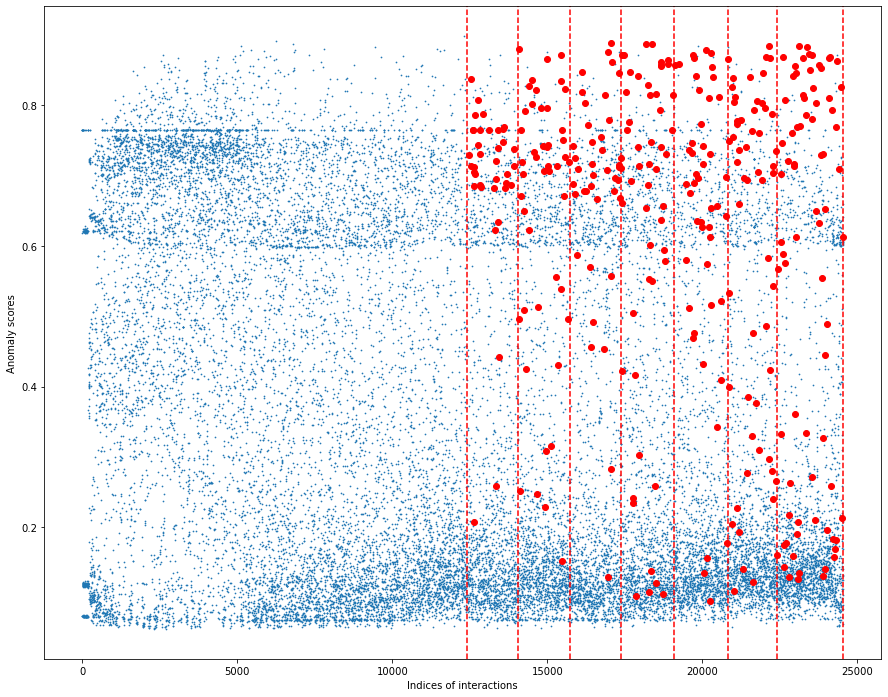

AUC - snap  0  :  0.9125482625482626
AUC - snap  1  :  0.8943150383909413
AUC - snap  2  :  0.8874421435320874
AUC - snap  3  :  0.8403379953379954
AUC - snap  4  :  0.8789513603444901
AUC - snap  5  :  0.8563646647975998
AUC - snap  6  :  0.8358111809247624
Total AUC (on the test set) :  0.8631836437656023


In [27]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
plt.figure(figsize=(15,12))
plt.scatter(np.arange(len(full_data.sources)), anomaly_scores, s=0.5)
for edge in anom_edges:
    plt.scatter(edge, anomaly_scores[edge], c='red')
for snap in snaps_indices:
    plt.axvline(x=snap, color='red', linestyle='--')
plt.xlabel('Indices of interactions')
plt.ylabel("Anomaly scores")
plt.show()

for i in range(len(snaps_indices)-1):
    y_test = np.zeros(int(snaps_indices[i+1]-snaps_indices[i]))
    for edge in anom_edges:
        if snaps_indices[i] <= edge and edge <= snaps_indices[i+1]:
            y_test[edge-snaps_indices[i]] = 1
    auc = metrics.roc_auc_score(y_test, anomaly_scores[snaps_indices[i]:snaps_indices[i+1]])
    print("AUC - snap ", i, " : ", auc)

y_test = np.zeros(len(full_data.sources)-snaps_indices[0])
y_test[np.array(anom_edges)-snaps_indices[0]] = 1
auc = metrics.roc_auc_score(y_test, anomaly_scores[snaps_indices[0]:])
print("Total AUC (on the test set) : ", auc)

## D. Not to modify: reliability module

### 1) Reliability scores computation

In [23]:
def my_loss(output):
    return 1-output

model.memory.__init_memory__()
model.set_neighbor_finder(full_ngh_finder)
nodes = np.unique(np.hstack((full_data.sources,full_data.destinations)))
    
TEST_BATCH_SIZE = 1
num_test_instance = len(full_data.sources)
num_test_batch = math.ceil(num_test_instance / TEST_BATCH_SIZE)

for p in model.parameters():
    p.requires_grad = False

node_confidence = np.empty((model.n_nodes,),dtype=object)
colors2confidence = np.empty((model.n_nodes,),dtype=object)
for i in range(len(node_confidence)):
    node_confidence[i] = []
    colors2confidence[i] = []
interaction_confidence = np.zeros(num_test_instance)
anom_score = np.zeros(num_test_instance)
grad_src = []
grad_dst = []
for k in range(num_test_batch):
    loss = 0
    
    s_idx = k * TEST_BATCH_SIZE
    e_idx = min(num_test_instance, s_idx + TEST_BATCH_SIZE)
    
    sources_batch = full_data.sources[s_idx:e_idx]
    destinations_batch = full_data.destinations[s_idx:e_idx]
    timestamps_batch = full_data.timestamps[s_idx:e_idx]
    edge_idxs_batch = full_data.edge_idxs[s_idx: e_idx]
        
    size = len(sources_batch)
    
    memory, _ = model.get_updated_memory(list(range(model.n_nodes)),
                                                      model.memory.messages)
    
        #  Src attributes and memory
    
    source_nodes_features = model.node_raw_features[sources_batch, :]
    source_nodes_memory = memory[sources_batch, :]
    
        # Dst attributes and memory
    
    destination_nodes_features = model.node_raw_features[destinations_batch, :]
    destination_nodes_memory = memory[destinations_batch, :]
    
        #  Neighbors attributes and memory + edge attributes
        
    all_nodes = np.concatenate([sources_batch, destinations_batch, destinations_batch])
    timestamps = np.concatenate([timestamps_batch, timestamps_batch, timestamps_batch])
    
    neighbors, edge_idxs, edge_times = model.neighbor_finder.get_temporal_neighbor(
        all_nodes,
        timestamps,
        n_neighbors=10)

    neigh_features = model.node_raw_features[neighbors, :]
    neigh_memory = memory[neighbors, :]

    e_features = model.edge_raw_features[edge_idxs, :]
    
        # Gradient w.r.t. these quantities
    
    source_nodes_features.requires_grad = True
    source_nodes_memory.requires_grad = True
    destination_nodes_features.requires_grad = True
    destination_nodes_memory.requires_grad = True
    neigh_features.requires_grad = True
    neigh_memory.requires_grad = True
    e_features.requires_grad = True
    
    pos_prob, neg_prob = model.compute_edge_probabilities_grad(sources_batch, destinations_batch,
                                                        destinations_batch, timestamps_batch, edge_idxs_batch,
                                                        source_nodes_features, source_nodes_memory,
                                                        destination_nodes_features, destination_nodes_memory,
                                                        neigh_features, neigh_memory, e_features, NUM_NEIGHBORS)


    loss = my_loss(pos_prob.squeeze())
    loss.backward()

    src_confidence = 2*np.linalg.norm(source_nodes_memory.grad.detach().numpy(), axis = 1)[0] + 2*np.linalg.norm(neigh_features.grad.detach().numpy()[0]) + np.linalg.norm(e_features.grad.detach().numpy()[0])
    dst_confidence = 2*np.linalg.norm(destination_nodes_memory.grad.detach().numpy(), axis = 1)[0] + 2*np.linalg.norm(neigh_memory.grad.detach().numpy()[1]) + np.linalg.norm(e_features.grad.detach().numpy()[1])
    node_confidence[sources_batch[0]].append(src_confidence)
    node_confidence[destinations_batch[0]].append(dst_confidence)
    colors2confidence[sources_batch[0]].append('b')
    colors2confidence[destinations_batch[0]].append('r')
    interaction_confidence[k] = node_confidence[sources_batch[0]][-1]+node_confidence[destinations_batch[0]][-1]
    anom_score[k] = 1-pos_prob
    if k%100 == 0:
        print(k, '/', len(full_data.sources))
    source_nodes_features.requires_grad = False
    source_nodes_memory.requires_grad = False
    destination_nodes_features.requires_grad = False
    destination_nodes_memory.requires_grad = False
    neigh_features.requires_grad = False
    neigh_memory.requires_grad = False
    e_features.requires_grad = False
    loss = 0

0 / 24539
100 / 24539
200 / 24539
300 / 24539
400 / 24539
500 / 24539
600 / 24539
700 / 24539
800 / 24539
900 / 24539
1000 / 24539
1100 / 24539
1200 / 24539
1300 / 24539
1400 / 24539
1500 / 24539
1600 / 24539
1700 / 24539
1800 / 24539
1900 / 24539
2000 / 24539
2100 / 24539
2200 / 24539
2300 / 24539
2400 / 24539
2500 / 24539
2600 / 24539
2700 / 24539
2800 / 24539
2900 / 24539
3000 / 24539
3100 / 24539
3200 / 24539
3300 / 24539
3400 / 24539
3500 / 24539
3600 / 24539
3700 / 24539
3800 / 24539
3900 / 24539
4000 / 24539
4100 / 24539
4200 / 24539
4300 / 24539
4400 / 24539
4500 / 24539
4600 / 24539
4700 / 24539
4800 / 24539
4900 / 24539
5000 / 24539
5100 / 24539
5200 / 24539
5300 / 24539
5400 / 24539
5500 / 24539
5600 / 24539
5700 / 24539
5800 / 24539
5900 / 24539
6000 / 24539
6100 / 24539
6200 / 24539
6300 / 24539
6400 / 24539
6500 / 24539
6600 / 24539
6700 / 24539
6800 / 24539
6900 / 24539
7000 / 24539
7100 / 24539
7200 / 24539
7300 / 24539
7400 / 24539
7500 / 24539
7600 / 24539
7700 / 2453

### 2) Results

In [24]:
if Path(f'./data/anom_edges/{data_set}_anom_edges.csv').is_file():
    anom_edges = pd.read_csv(f'./data/anom_edges/{data_set}_anom_edges.csv').to_numpy().T[0]

reliability_score = 1 - interaction_confidence/max(interaction_confidence)

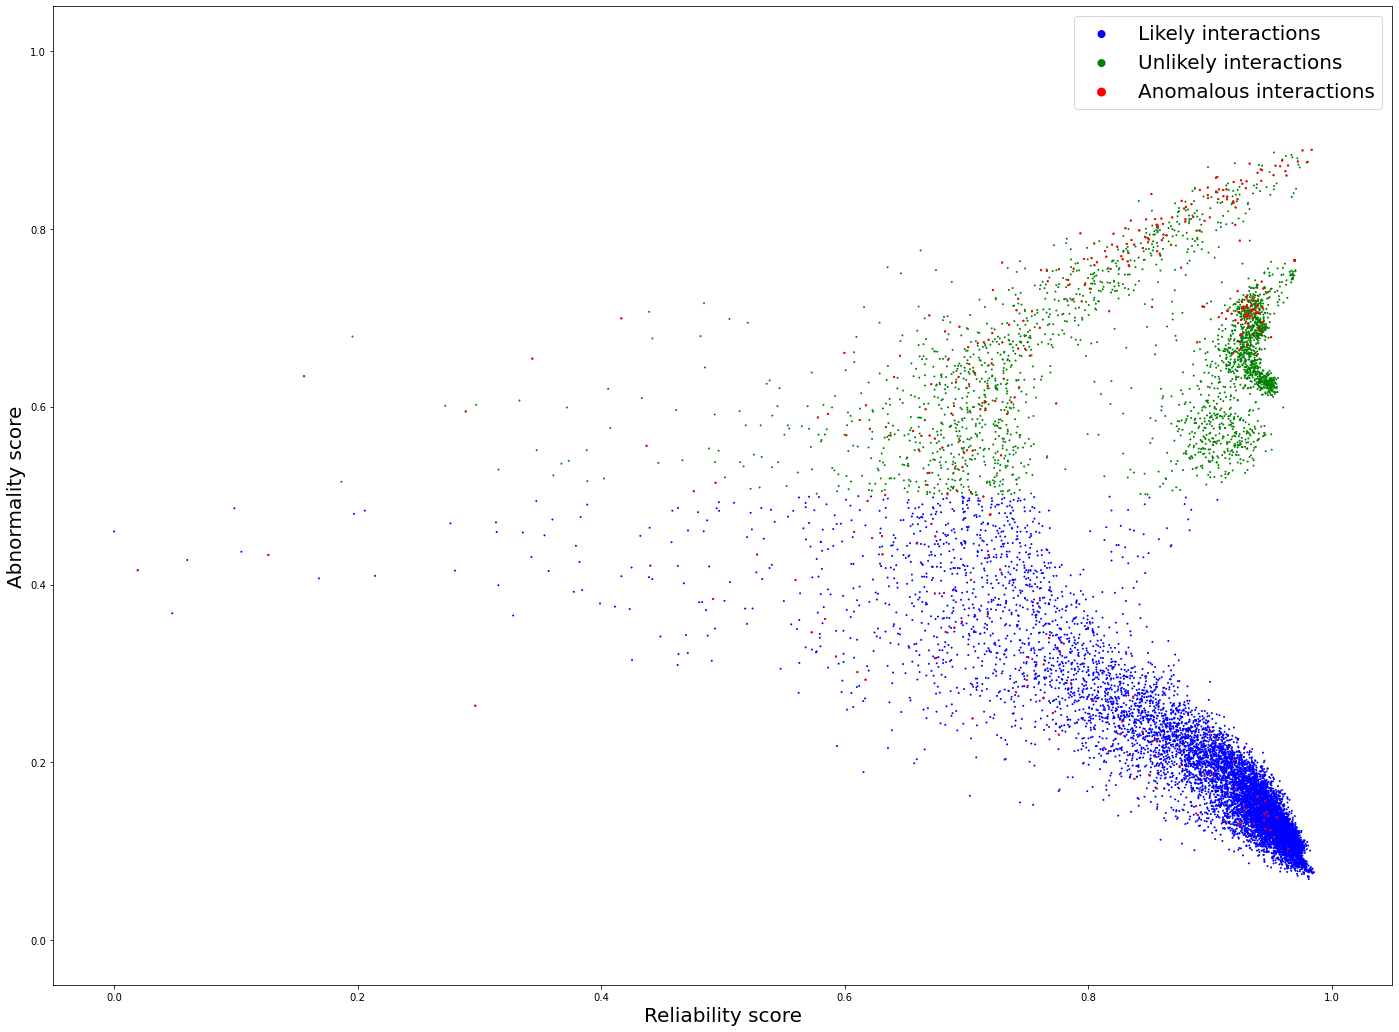

In [26]:
colors = []
for i in range(len(anom_score)):
    colors.append('b')
for interaction in np.where(anom_score<=0.5)[0]:
    colors[interaction] = 'g'
for interaction in anom_edges:
    colors[interaction] = 'r'
    
if Path(f'./data/snaps/{data_set}_snaps.csv').is_file():
    snaps_indices = pd.read_csv(f'./data/snaps/{data_set}_snaps.csv').to_numpy().T[0]
else:
    snaps_indices = np.array([0, len(full_data.sources)])
    
snap = snaps_indices[0]

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
fig, ax = plt.subplots(figsize=(24,18))
ax.scatter(reliability_score[snap:][np.where(anom_score[snap:]<=0.5)[0]],
           anom_score[snap:][np.where(anom_score[snap:]<=0.5)[0]], c='b', s=4, label='Likely interactions', edgecolors='none')
ax.scatter(reliability_score[snap:][np.where(anom_score[snap:]>0.5)[0]],
           anom_score[snap:][np.where(anom_score[snap:]>0.5)[0]], c='g', s=4, label="Unlikely interactions", edgecolors='none')
ax.scatter(reliability_score[anom_edges],
           anom_score[anom_edges], c='r', s=5, label="Anomalous interactions", edgecolors='none')
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.legend(markerscale=4,prop=dict(size=20))

ax.set_xlabel('Reliability score', fontsize = 20)
ax.set_ylabel('Abnormality score', fontsize = 20)
plt.show()